# Двумерные уравнения "мелкой воды"

Данный код решает двумерные уравнения "мелкой воды" -- важную модель сплошной среды, имеющую приложения для моделирования атмосферы и океанов планет. В качестве задания предлагается промоделировать ряд задач геофизики (рассмотреть уравнения при наличии силы Кориолиса и переменной глубины дна. В качестве референса и начальных данных можно использовать ресурс https://www.met.reading.ac.uk/~swrhgnrj/shallow_water_model/

## Уравнения модели

Уравнения имеют вид:

$$
\begin{aligned}
\frac{\partial h}{\partial t} + \frac{\partial (h v_x)}{\partial x} + \frac{\partial (h v_y)}{\partial y} &= 0 \quad &\text{(уравнение на высоту столба жидкости } h) \\
\frac{\partial (h v_x)}{\partial t} + \frac{\partial (h v_x^2 + \frac{1}{2}g h^2)}{\partial x} + \frac{\partial (h v_x v_y)}{\partial y} &= -g H \frac{\partial b}{\partial x} \quad &\text{(уравнение для скорости жидкости } v_x) \\
\frac{\partial (h v_y)}{\partial t} + \frac{\partial (h v_x v_y)}{\partial x} + \frac{\partial (h v_y^2 + \frac{1}{2}g h^2)}{\partial y} &= -g h \frac{\partial b}{\partial y} \quad &\text{(уравнение для скорости жидкости } v_y)
\end{aligned}
$$

где:
- $g$ — ускорение свободного падения
- $b$ — функция рельефа бассейна -- зависимость высоты дна от (x,y) (в правую часть уравнений входит ее градиент)

## Компактная форма записи

Система может быть записана в векторной форме в виде законов сохранения:

$$
\frac{\partial \vec{U}}{\partial t} + \frac{\partial \vec{F_x}}{\partial x} + \frac{\partial \vec{F_y}}{\partial y} = \vec{S}
$$

## Ключевые особенности

Программа реализует конечно-объемную схему второго порядка точности для решения уравнений мелкой воды. Поддерживаются различные типы граничных условий и начальных возмущений. Вычисления векторизованы с использованием NumPy для эффективной работы. Визуализация адаптируется под 1D или 2D случай.

In [40]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  В данном блоке задаются необходимые нам библиотеки и некоторые константы.
#  
#######################################################################################################################
#######################################################################################################################
'''

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output  # добавляем импорт clear_output и display для визуализации во время расчета 
import time
from collections import namedtuple
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys

In [41]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  В данном блоке реализована функция построения двумерной сетки.
#  Для использования метода конечного объема зададим двумерную сетку, покрывающую наш "бассейн" (вид в изометрии) --
#  она имеет вид двумерной призмы единичной высоты, которая разделена на ячейки вдоль направлений X и Y
#  (призма имеет параметры x*y*z = x1*x2*x3 = (xmax - xmin)*(ymax - ymin)*1, которую мы "нарезаем" вдоль x1 и x2)
#  
#            +-----+-----+-----+-----+-----+-----+-----+-----+
#        dy /     /     /     /     /     /     /     /     /|
#          +-----+-----+-----+-----+-----+-----+-----+-----+ +
#         /     /     /     /     /     /     /     /     /|/
#        +-----+-----+-----+-----+-----+-----+-----+-----+ +
#       /     /     /     /     /     /     /     /     /|/
#      +-----+-----+-----+-----+-----+-----+-----+-----+ +
#     /     /     /     /     /     /     /     /     /|/
#    +-----+-----+-----+-----+-----+-----+-----+-----+ +
#  1 |     |     |     |     |     |     |     |     |/
#    +-----+-----+-----+-----+-----+-----+-----+-----+ 
#      dx
#
#######################################################################################################################
#######################################################################################################################
'''

def grid_setup_2D(xmin, xmax, ymin, ymax, Nx, Ny):

    #число фиктивных ячеек 
    Ng = 2
    
    #разрешение сетки dx = const
    dx = (xmax - xmin)/Nx
    #разрешение сетки dy = const
    dy = (ymax - ymin)/Ny

    #задаем площади граней вдоль оси X, fSx(i,j) = dy*1 (только реальные ячейки)
    fSx = np.full((Nx + 1, Ny), 1.0 * dy)

    #задаем площади граней вдоль оси Y, fSy(i,j) = dx*1 (только реальные ячейки)
    fSy = np.full((Nx, Ny + 1), 1.0 * dx)

    #задаем объем ячейки сVol(i,j) = dx*dy*1 (только реальные ячейки)
    cVol = np.full((Nx, Ny), 1.0 * dx * dy)
    
    #координата центра ячейки вдоль x1, cx1(i) = x1min + (i - 1/2)*dx1
    cx = np.tile(np.linspace(xmin - (Ng - 0.5) * dx, xmax + (Ng - 0.5) * dx, \
        Nx + Ng * 2, dtype=np.double), (Ny + Ng*2, 1)).T
    
    #координата грани ячейки вдоль x, fx(i) = xmin + (i - 1)*dx
    #(внутренняя грань имеет тот же индекс, что и ячейка)
    fx = np.tile(np.linspace(xmin - Ng * dx, xmax + Ng * dx, \
        Nx + 2 * Ng + 1, dtype=np.double), (Ny + Ng*2, 1)).T

    #координата центра ячейки вдоль y, сy(j) = ymin + (j - 1/2)*dy
    cy = np.tile(np.linspace(ymin - (Ng - 0.5) * dy, ymax + (Ng - 0.5) * dy, \
        Ny + Ng * 2, dtype=np.double), (Nx + Ng*2, 1))

    #координата грани ячейки вдоль y, fy(j) = ymin + (j - 1)*dy 
    #(внутренняя грань имеет тот же индекс, что и ячейка)
    fy = np.tile(np.linspace(ymin - Ng * dy, ymax + Ng * dy, \
        Ny + Ng * 2 + 1, dtype=np.double), (Nx + Ng*2, 1))

    #создаем именованный кортеж, чтобы все данные про сетку были в одной структуре
    Grid = namedtuple('Grid', [
        'Ng', 'dx', 'dy', 'fSx', 'fSy', 'cVol',
        'cx', 'cy', 'fx', 'fy',
        'Nx', 'Ny', 'xmin', 'xmax', 'ymin', 'ymax'
    ])

    #возвращаем структуру данных про сетку
    return Grid(
        Ng, dx, dy, fSx, fSy, cVol,
        cx, cy, fx, fy,
        Nx, Ny, xmin, xmax, ymin, ymax
    )

In [42]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  В данном блоке реализованы процедуры визуализации.
#
#######################################################################################################################
#######################################################################################################################
'''
def plot_setup(grid, var, time):
    
    Ng = grid.Ng
    im = 0
    line = 0
    
    #plotting
    if (grid.Ny == 1):
        fig, ax = plt.subplots()
        line, = ax.plot(grid.cx[Ng:-Ng,Ng], var[Ng:-Ng,Ng])
        ax.set_title('sol at time = ' + str(np.round(time, 4)))
        ax.set_xlabel('x')
        ax.set_ylabel('solution')
        plt.close()  
    
    elif (grid.Nx == 1): 
        fig, ax = plt.subplots()
        line, = ax.plot(grid.cy[Ng,Ng:-Ng], var[Ng,Ng:-Ng])
        ax.set_title('sol at time = ' + str(np.round(time, 4)))
        ax.set_xlabel('y')
        ax.set_ylabel('solution')
        plt.close()  
        
    else:
        # figures and axes
        fig, ax = plt.subplots()
        varmin = np.min(var[Ng:-Ng, Ng:-Ng])
        varmax = np.max(var[Ng:-Ng, Ng:-Ng])
        im = ax.imshow(var[Ng:-Ng, Ng:-Ng], origin='lower', \
            extent=[grid.cy[Ng,Ng], grid.cy[Ng,grid.Ny+Ng], \
            grid.cx[Ng,Ng], grid.cx[grid.Nx+Ng,Ng]], vmin=0.8, vmax=1.2)
        ax.set_title('solution at time = ' + str(np.round(time, 2)))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        cbar = plt.colorbar(im, ax=ax) 
        plt.ion()
        plt.show()

    return line, ax, fig, im


def plotting(grid,var,time, line, ax, fig, im):

    Ng = grid.Ng
    if (grid.Ny == 1): 
        line.set_data(grid.cx[Ng:-Ng,Ng], var[Ng:-Ng,Ng])
        ax.set_title('solution at time = '+ str(np.round(time, 4)))
        ax.relim()
        ax.autoscale_view()        
                
    if (grid.Nx == 1):
        line.set_data(grid.cy[Ng,Ng:-Ng], var[Ng,Ng:-Ng])
        ax.set_title('solution at time = '+ str(np.round(time, 4)))
        
        ax.relim()
        ax.autoscale_view()
            
    if ((grid.Nx != 1) & (grid.Ny != 1)):
        varmin = np.min(var[Ng:-Ng, Ng:-Ng])
        varmax = np.max(var[Ng:-Ng, Ng:-Ng])
        im = ax.imshow(var[Ng:-Ng, Ng:-Ng], origin='lower', \
            extent=[grid.cy[Ng,Ng], grid.cy[Ng,grid.Ny+Ng], \
            grid.cx[Ng,Ng], grid.cx[grid.Nx+Ng,Ng]], vmin=0.8, vmax=1.2)
        
        im.set_data(var[Ng:-Ng, Ng:-Ng]) 
        ax.set_title('solution at time = '+ str(np.round(time, 4)))
                 
    clear_output(wait=True)
    plt.pause(0.05)
    display(fig)

In [43]:
'''
#######################################################################################################################
#######################################################################################################################
#   
#  В данном блоке создается вектор состояния нашей среды 
#  h - высота столба жидкости 
#  vx - скорость жидкости в направлении (X)
#  vy - скорость жидкости в направлении (Y)
#  g - ускорение свободного падения 
#  b - локальный уровень дна в бассейне (данная величина здесь для полноты, т.к. мы используем только ее градиент)
#  b_x - производная по x от функции уровня дна (изменение рельефа дна по X)
#  b_y - производная по y от функции уровня дна (изменение рельефа дна по Y)
#  f_cor - параметр для силы Кориолиса (рассмотрим константу)
#  BC -- маркер границы 
#
#######################################################################################################################
#######################################################################################################################
'''

def set_SW_State(grid):

    #переобозначим для удобства количество ячеек
    Nx = grid.Nx
    Ny = grid.Ny
    #число фиктивных ячеек всегда = 2
    Ng = 2
    
    #высота столба жидкости в бассейне 
    h = np.ones((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    #скорость вдоль направления 1 (направления X)
    vx = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    #скорость вдоль направления 2 (направления Y)
    vy = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)

    #ускорение свободного падения
    g = 1.0

    #параметр Кориолиса (по умолчанию ноль)
    f_c = 0.0

    #локальный уровень дна в бассейне
    b = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    #производная по направлению 1 (направлению X) от высоты дна бассейна
    b_x = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    #производная по направлению 2 (направлению Y) от высоты дна бассейна
    b_y = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)

    # маркер границы задается здесь (возможны 3 типа границы -- 'wall, 'free' и 'periodic', 
    # которые соответствуют твердой стенке, свободному истечению и периодическому граничному условию)
    # В соответствии с этим маркером будут присваиваться значения для жидкости в фиктивных ячейках
    BC = np.array(['wall', 'periodic', 'wall', 'periodic'], dtype=str)

    #создаем переменную для финального времени 
    time_fin = 1.0
    
    #создаем словарь с состоянием среды (Shallow Water State = SWS)
    SWS = {
        'h': h,
        'vx': vx,
        'vy': vy,
        'b' : b,
        'b_x' : b_x,
        'b_y' : b_y,
        'g' : g,
        'f_c' : f_c,
        'BC' : BC
    }        

    return SWS

In [44]:
'''
#######################################################################################################################
#######################################################################################################################
#   
#  В данном блоке находится решение задачи о распаде разрыва (задачи Римана (далее ЗР)) 
#  для двумерных уравнений мелкой воды. Решение ищется вдоль оси X 
#  (решение вдоль второго направления Y можно найти, просто повернув на 90 градусов систему координат)
#  
#  h -- высота жидкости
#  vx - скорость жидкости в направлении (X)
#  vy - скорость жидкости в направлении (Y)
#  g - ускорение свободного падения 
#
# 
#  
#######################################################################################################################
#######################################################################################################################
'''

def Riemann_flux_SWE(hl, hr, vxl, vxr, vyl, vyr, g, dim):

    '''
    Функция вычисляет потоки для уравнений мелкой воды с использованием приближения HLL.

    Parameters
    ----------
    hl, hr : float
        Высота жидкости слева и справа от границы.
    vxl, vxr : float
        Скорость по x слева и справа от границы.
    vyl, vyr : float
        Скорость по y слева и справа от границы.
    g : float
        Ускорение свободного падения.
    dim : str
        Направление ('x' или 'y').

    Returns
    -------
    Fh, Fhvx, Fhvy : float
        Потоки высоты и "импульса".
    '''
    
    #если решаем ЗР вдоль Y -- повернем систему координат так, чтобы решать задачу вдоль оси X' и использовать для этого  
    # ту же самую процедуру, что и для ЗР вдоль оси X
    if dim == 'y':
        templ, tempr = vxl, vxr
        vxl, vxr = vyl, vyr
        vyl, vyr = -templ, -tempr 
    
    #оценки для максимального и минимального собственного значения в системе согласно работе Davis (1988)
    #они уже учитывают все 3 состояния между двумя ударными волнами
    Sl = np.minimum(np.minimum(vxl, vxr) - np.maximum(np.sqrt(g * hl), np.sqrt(g * hr)), 0.0)
    Sr = np.maximum(np.maximum(vxl, vxr) + np.maximum(np.sqrt(g * hl), np.sqrt(g * hr)), 0.0)
    
    #схема LLF -- более диссипативная 
    #Sr = np.maximum(np.abs(vxl) + np.sqrt(g * hl), np.abs(vxr) + np.sqrt(g * hr))
    #Sl = -Sr
    
    # Находим потоки согласно методу HLL (3 состояния среды, ограниченные двумя "ударными волнами") --
    # в нашем случае это разрывы в высоте жидкости, распространяющиеся со скоростями (Vx +- sqrt(g*H)) 
    Fh = (Sr*hl*vxl - Sl*hr*vxr + Sr*Sl*(hr - hl))/(Sr - Sl)
    Fhvx = (Sr*(hl*vxl**2 + 0.5*g*hl**2) - Sl*(hr*vxr**2 + 0.5*g*hr**2) + Sr*Sl*(hr*vxr - hl*vxl))/(Sr - Sl)
    Fhvy = (Sr*(hl*vxl*vyl) - Sl*(hr*vxr*vyr) + Sr*Sl*(hr*vyr - hl*vyl))/(Sr - Sl)
    
    #если решаем ЗР вдоль Y -- повернем систему координат в исходное состояние 
    if dim == 'y': 
        temp = Fhvx
        Fhvx = -Fhvy
        Fhvy = temp
        
    #Возвращаем итоговые значения для потоков в уравнениях мелкой воды
    #3 потока для сохраняющихся величин (потоки "высоты" и потоки для для "импульса" в направлениях X и Y)
    return Fh, Fhvx, Fhvy

In [45]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  Заполнение физических величин в фиктивных ячейках значениями в соответствии с граничными условиями
#  
#  input:
#      1) "grid" -- структура (кортеж) с сеточными данными (см. выше)
#      2) "SWS" -- структура (словарь) с текущим состоянием среды (см. выше)
#  output: 
#      SWS -- Допустимый шаг по времени из условия Куранта-Фридрихса-Леви
#  
#  @author: mrkondratyev
# 
#######################################################################################################################
#######################################################################################################################
'''

def ghost_cells_SWE(grid, SWS):

    #переобозначили индексы для упрощения
    Ng = grid.Ng
    Nx = grid.Nx
    Ny = grid.Ny

    #границы вдоль x
    for i in range(0,Ng):
        #внутренняя граница вдоль x
        if SWS['BC'][0] == 'free': #non-reflective boundary
            SWS['h'][i, :] = SWS['h'][2 * Ng - 1 - i, :]
            SWS['vx'][i, :] = SWS['vx'][2 * Ng - 1 - i, :]
            SWS['vy'][i, :] = SWS['vy'][2 * Ng - 1 - i, :]
        elif SWS['BC'][0] == 'wall': #reflective (wall or symmetry) boundary
            SWS['h'][i, :] = SWS['h'][2 * Ng - 1 - i, :]
            SWS['vx'][i, :] = - SWS['vx'][2 * Ng - 1 - i, :]
            SWS['vy'][i, :] = SWS['vy'][2 * Ng - 1 - i, :] 
        elif SWS['BC'][0] == 'periodic': #periodic boundary
            SWS['h'][i, :] = SWS['h'][Nx + i, :]
            SWS['vx'][i, :] = SWS['vx'][Nx + i, :]
            SWS['vy'][i, :] = SWS['vy'][Nx + i, :]
            
        #внешняя граница вдоль x
        if SWS['BC'][2] == 'free': #non-reflective boundary
            SWS['h'][Nx + Ng + i, :] = SWS['h'][Nx + Ng - 1 - i, :]
            SWS['vx'][Nx + Ng + i, :] = SWS['vx'][Nx + Ng - 1 - i, :]
            SWS['vy'][Nx + Ng + i, :] = SWS['vy'][Nx + Ng - 1 - i, :]
        elif SWS['BC'][2] == 'wall': #reflective (wall or symmetry) boundary
            SWS['h'][Nx + Ng + i, :] = SWS['h'][Nx + Ng - 1 - i, :]
            SWS['vx'][Nx + Ng + i, :] = - SWS['vx'][Nx + Ng - 1 - i, :]
            SWS['vy'][Nx + Ng + i, :] = SWS['vy'][Nx + Ng - 1 - i, :]
        elif SWS['BC'][2] == 'periodic': #periodic boundary
            SWS['h'][Nx + Ng + i, :] = SWS['h'][Ng + i, :]
            SWS['vx'][Nx + Ng + i, :] = SWS['vx'][Ng + i, :]
            SWS['vy'][Nx + Ng + i, :] = SWS['vy'][Ng + i, :]

    #границы вдоль y
    for i in range(0,Ng):
        #внутренняя граница вдоль y
        if SWS['BC'][1] == 'free': #non-reflective boundary
            SWS['h'][:, i] = SWS['h'][:, 2 * Ng - 1 - i]
            SWS['vx'][:, i] = SWS['vx'][:, 2 * Ng - 1 - i]
            SWS['vy'][:, i] = SWS['vy'][:, 2 * Ng - 1 - i]
        elif SWS['BC'][1] == 'wall': #reflective (wall or symmetry) boundary
            SWS['h'][:, i] = SWS['h'][:, 2 * Ng - 1 - i]
            SWS['vx'][:, i] = SWS['vx'][:, 2 * Ng - 1 - i]
            SWS['vy'][:, i] = - SWS['vy'][:, 2 * Ng - 1 - i]
        elif SWS['BC'][1] == 'periodic': #periodic boundary
            SWS['h'][:, i] = SWS['h'][:, Ny + i]
            SWS['vx'][:, i] = SWS['vx'][:, Ny + i]
            SWS['vy'][:, i] = SWS['vy'][:, Ny + i]
                
        #внешняя граница вдоль y
        if SWS['BC'][3] == 'free': #non-reflective boundary
            SWS['h'][:, Ny + Ng + i] = SWS['h'][:, Ny + Ng - 1 - i]
            SWS['vx'][:, Ny + Ng + i] = SWS['vx'][:, Ny + Ng - 1 - i]
            SWS['vy'][:, Ny + Ng + i] = SWS['vy'][:, Ny + Ng - 1 - i]
        elif SWS['BC'][3] == 'wall': #reflective (wall or symmetry) boundary
            SWS['h'][:, Ny + Ng + i] = SWS['h'][:, Ny + Ng - 1 - i]
            SWS['vx'][:, Ny + Ng + i] = SWS['vx'][:, Ny + Ng - 1 - i]
            SWS['vy'][:, Ny + Ng + i] = - SWS['vy'][:, Ny + Ng - 1 - i]
        elif SWS['BC'][3] == 'periodic': #periodic boundary
            SWS['h'][:, Ny + Ng + i] = SWS['h'][:, Ng + i]
            SWS['vx'][:, Ny + Ng + i] = SWS['vx'][:, Ng + i]
            SWS['vy'][:, Ny + Ng + i] = SWS['vy'][:, Ng + i]

    return SWS

In [46]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  Процедуры ниже реализуют кусочно-линейное уточнение по времени и пространству для второго порядка точности 
# 
#######################################################################################################################
#######################################################################################################################
'''

#функция-ограничитель (limiter) для обеспечения монотонности решения
def limiter(x, y):
    #анализатор гладкости 
    r = (y + 1e-14) / (x + 1e-14)
    #vanLeer limiter
    #df = 1.0 * x * (np.abs(r) + r) / (1.0 + np.abs(r))
    #MC-limiter
    df = x * np.maximum(0.0, np.minimum( (1.0 + r) / 2.0,  np.minimum(r * 2.0, 2.0)))
    
    #возвращаем "отфильтрованное" значение с учетом монотонности
    return df

#данная функция рассчитывает ограниченный кусочно-линейный градиент
def limited_gradient(grid, var):
    
    #переопределим числа ячеек для удобства
    Nxr = grid.Nx + 2
    Nyr = grid.Ny + 2
    Nx = grid.Nx
    Ny = grid.Ny

    #градиент вдоль направления x 
    #(считаем во всех реальных ячейках и в первых фиктивных ячейках)
    if (grid.Nx > 1):
        gvar_x_unlim = (var[1:Nxr+2, 1:-1] - var[0:Nxr+1, 1:-1]) / \
            (grid.cx[1:Nxr+2, 1:-1] - grid.cx[0:Nxr+1, 1:-1])     
        gvar_x = limiter(gvar_x_unlim[:-1, :], gvar_x_unlim[1:, :])
    else:
        gvar_x = np.zeros((Nxr, Nyr), dtype=np.double)

    #градиент вдоль направления y
    #(считаем во всех реальных ячейках и в первых фиктивных ячейках)
    if (grid.Ny > 1):
        gvar_y_unlim = (var[1:-1, 1:Nyr+2] - var[1:-1, 0:Nyr+1]) / \
            (grid.cy[1:-1, 1:Nyr+2] - grid.cy[1:-1, 0:Nyr+1])
        gvar_y = limiter(gvar_y_unlim[:, :-1], gvar_y_unlim[:, 1:])
    else: 
        gvar_y = np.zeros((Nxr, Nyr), dtype=np.double)

    #возвращаем линейно-ограниченный градиент
    return gvar_x, gvar_y


#данная функция расчитывает кусочно-линейные уточнения величин на гранях ячеек по времени и пространству
# второй порядок точности
def rec_plm_SWE(grid, dt, SWS):

    #переопределим числа ячеек для удобства
    Nxr = grid.Nx + 2
    Nyr = grid.Ny + 2
    
    #расчет ограниченных градиентов 
    h_x, h_y = limited_gradient(grid, SWS['h'])
    vx_x, vx_y = limited_gradient(grid, SWS['vx'])
    vy_x, vy_y = limited_gradient(grid, SWS['vy'])

    #производная по времени от высоты
    dhdt = -SWS['vx'][1:-1, 1:-1]*h_x - \
        SWS['vy'][1:-1, 1:-1]*h_y - \
        SWS['h'][1:-1, 1:-1]*(vx_x + vy_y)

    #производная по времени от скорости вдоль x (без источников)
    dvxdt = -SWS['vx'][1:-1, 1:-1]*vx_x - \
        SWS['vy'][1:-1, 1:-1]*vx_y - SWS['g']*h_x

    #производная по времени от скорости вдоль y (без источников)
    dvydt = -SWS['vx'][1:-1, 1:-1]*vy_x - \
        SWS['vy'][1:-1, 1:-1]*vy_y - SWS['g']*h_y

    hlx = SWS['h'][1:Nxr, 2:-2] + (dt/2.0)*dhdt[:-1,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[1:-2, 2:-2])*h_x[:-1,1:-1]
    hrx = SWS['h'][2:Nxr+1, 2:-2] + (dt/2.0)*dhdt[1:,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[2:-1, 2:-2])*h_x[1:,1:-1]

    vxlx = SWS['vx'][1:Nxr, 2:-2] + (dt/2.0)*dvxdt[:-1,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[1:-2, 2:-2])*vx_x[:-1,1:-1]
    vxrx = SWS['vx'][2:Nxr+1, 2:-2] + (dt/2.0)*dvxdt[1:,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[2:-1, 2:-2])*vx_x[1:,1:-1]

    vylx = SWS['vy'][Ng-1:Nxr, 2:-2] + (dt/2.0)*dvxdt[:-1,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[1:-2, 2:-2])*vy_x[:-1,1:-1]
    vyrx = SWS['vy'][Ng:Nxr+1, 2:-2] + (dt/2.0)*dvxdt[1:,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[2:-1, 2:-2])*vy_x[1:,1:-1]

    hly = SWS['h'][2:-2, 1:Nyr] + (dt/2.0)*dhdt[1:-1,:-1] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, Ng-1:-Ng])*h_y[1:-1,:-1] 
    hry = SWS['h'][2:-2, 2:Nyr+1] + (dt/2.0)*dhdt[1:-1,1:] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 2:-1])*h_y[1:-1,1:]

    vxly = SWS['vx'][2:-2, 1:Nyr] + (dt/2.0)*dvxdt[1:-1,:-1] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 1:-2])*vx_y[1:-1,:-1] 
    vxry = SWS['vx'][2:-2, 2:Nyr+1] + (dt/2.0)*dvxdt[1:-1,1:] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 2:-1])*vx_y[1:-1,1:]

    vyly = SWS['vy'][2:-2, 1:Nyr] + (dt/2.0)*dvydt[1:-1,:-1] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 1:-2])*vy_y[1:-1,:-1] 
    vyry = SWS['vy'][2:-2, 2:Nyr+1] + (dt/2.0)*dvydt[1:-1,1:] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 2:-1])*vy_y[1:-1,1:]
    
    return hlx, hrx, vxlx, vxrx, vylx, vyrx, hly, hry, vxly, vxry, vyly, vyry 


# Описание начальных условий

см. комментарии

In [47]:
'''
#######################################################################################################################
#######################################################################################################################
#
#  Начальные условия задаются здесь
#
#######################################################################################################################
#######################################################################################################################

'''
def SWE_init_cond(grid, SWS, init_cond_type):

    # прорыв плотины вдоль Ox -- название говорит само за себя :)
    # одномерная задача, описыавающая разрывные течения, возникающие при прорыве плотины
    if init_cond_type == 'dam_break_x':
        
        SWS['g'] = 1.0
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
                if grid.fx[i, j] < 0.5:
                    SWS['h'][i, j] = 1.0
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                else:
                    SWS['h'][i, j] = 0.125
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                       
        phys_time_fin = 0.3      
        SWS['BC'] = np.array(['free', 'free', 'free', 'free'], dtype=str)

    # прорыв плотины вдоль Oy
    elif init_cond_type == 'dam_break_y':
        
        SWS['g'] = 1.0
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
                if grid.fy[i, j] < 0.5:
                    SWS['h'][i, j] = 1.0
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                else:
                    SWS['h'][i, j] = 0.125
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                    
        phys_time_fin = 0.3       
        SWS['BC'] = np.array(['free', 'free', 'free', 'free'], dtype=str)

    #течение воды в ванне 
    elif init_cond_type == 'bathtub':
    
        SWS['g'] = 9.8
        x0 = grid.xmin + (grid.xmax - grid.xmin)/2.0
        y0 = grid.ymin + (grid.ymax - grid.ymin)/2.0
        
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
            
                r = np.sqrt((grid.cx[i,j] - x0)**2 + (grid.cy[i,j]-y0)**2)
                func = (np.sin(r) + 1e-14)/(r + 1e-14)
                if r > np.pi:
                    func = 0.0
                    
                SWS['h'][i, j] = 1.0 + 1.0*func
                SWS['vx'][i, j] = 0.0
                SWS['vy'][i, j] = 0.0
                    
        phys_time_fin = 150.0        
        SWS['BC'] = np.array(['wall', 'wall', 'wall', 'wall'], dtype=str)

    elif init_cond_type == 'tsunami':
        #SWS['g'] = 9.81
        
        #зададим форму дна
        #for i in range(grid.Ngc-1, grid.Nx + grid.Ng + 1):
            #for j in range(grid.Ngc-1, grid.Nx + grid.Ng + 1):
                #SWS['b'][i, j] = 0.0
                #SWS['b_x'][i, j] = 0.0
                #SWS['b_y'][i, j] = 0.0

        #зададим функции решения
        #for i in range(grid.Ng, grid.Nx + grid.Ng):
            #for j in range(grid.Ng, grid.Ny + grid.Ng):
                #SWS['h'][i,j] = 1.0 + 0.1*np.exp(-(grid.cx[i,j] - 0.3)**2/0.01)
                #SWS['vx'][i, j] = 0.0
                #SWS['vy'][i, j] = 0.0
                 
        #phys_time_fin = 1.0    
        SWS['BC'] = np.array(['free', 'wall', 'free', 'wall'], dtype=str)

    elif init_con_type == 'atmosphere':
        f_coriolis = 1e-4
        beta = 1.6e-11
        SWS['g'] = 9.81
        
        #зададим форму дна
        #for i in range(grid.Ngc-1, grid.Nx + grid.Ng + 1):
            #for j in range(grid.Ngc-1, grid.Nx + grid.Ng + 1):
                #SWS['b'][i, j] = 0.0
                #SWS['b_x'][i, j] = 0.0
                #SWS['b_y'][i, j] = 0.0

        #зададим функции решения
        #for i in range(grid.Ng, grid.Nx + grid.Ng):
            #for j in range(grid.Ng, grid.Ny + grid.Ng):
                #SWS['h'][i,j] = 1.0 + 0.1*np.exp(-(grid.cx[i,j] - 0.3)**2/0.01)
                #SWS['vx'][i, j] = 0.0
                #SWS['vy'][i, j] = 0.0
    
        #phys_time_fin = 1.0    
        SWS['BC'] = np.array(['periodic', 'wall', 'periodic', 'wall'], dtype=str)
    
    # если не задан тип начального условия из списка -- выдадим ошибку
    else:
        phys_time_fin = 0.0
        sys.exit("error, choose initial condions from the list in function SWE_init_cond")
        
    return SWS, phys_time_fin



# Описание основного блока программы

## Инициализация расчетной области

Программа начинается с задания параметров вычислительной сетки: границ расчетной области (xmin, xmax, ymin, ymax), количества ячеек (Nx, Ny) и числа фиктивных ячеек для граничных условий (Ng). Создается структура сетки grid, инициализируются структуры данных для хранения состояния системы (SWS0, SWSh, SWS1 -- состояния среды до (SWS0) и после (SWS1) шага по времени, а также промежуточное значение (SWSh))

## Настройка начальных условий

Выбирается тип начальных условий (dam_break_x, dam_break_y или bathtub), которые определяют начальное распределение высоты жидкости $h$ и скоростей $v_x$, $v_y$ (остальные параметры задаются там же). Также задается время окончания расчета phys_time_fin.


## Основной временной цикл

    1. Расчет шага по времени: Определяется максимально допустимый шаг dt из условия устойчивости Куранта-Фридрихса-Леви (CFL), учитывающего скорости течения и глубину жидкости.

    2. Обработка граничных условий: Заполняются фиктивные ячейки в соответствии с выбранным типом граничных условий (стенка, свободный выход или периодические).

    2. Кусочно-линейная реконструкция: Для повышения точности до второго порядка выполняется реконструкция переменных на гранях ячеек.

    3. Расчет потоков: На гранях ячеек вычисляются потоки массы и импульса с использованием приближенного решения задачи Римана (HLL-метод).

    4. Обновление переменных: Интегрируются уравнения мелкой воды - обновляются значения высоты жидкости и компонент скорости.

    5. Перезапись состояния: Текущее состояние системы копируется для использования на следующем шаге по времени.

    6. Визуализация: Каждые 50 шагов выводится текущее состояние системы для визуального контроля.

## Учет дополнительной физики

Для решения уравнений мелкой воды при наличии градиента глубины дна и при наличии силы Кориолиса вводятся источники, они интегрируются явно по времени с использованием процедуры расщепления: 

\begin{aligned}
{\bf U}_t + \nabla\cdot{\bf F(\bf U)} = {\bf S(\bf U)} \quad &\text{(исходная система}) \\ 
{\bf U}' = {\bf U}^n + \frac{\Delta t}{2}{\bf S(\bf U^n)}\quad &\text{(1-ая стадия (полшага)})\\
{\bf U}'' = {\bf U}' - \Delta t\nabla\cdot{\bf F({\bf U'})} \quad &\text{(2-ая стадия (расчет системы без источников; шаг)}) \\
{\bf U}^{n+1} = {\bf U}'' + \frac{\Delta t}{2}{\bf S(\bf U'')} \quad &\text{(3-я стадия (полшага)})
\end{aligned}

В итоге получаем схему со вторым порядком по времени


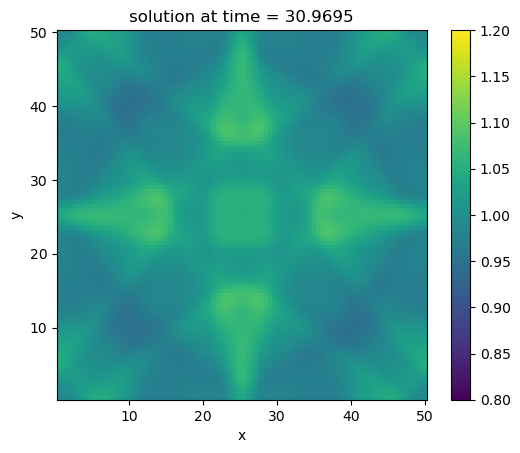

KeyboardInterrupt: 

In [54]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  Здесь начинается основной код программы
#  
#######################################################################################################################
#######################################################################################################################
'''
#задаем границы нашей прямоугольной области
xmin = 0.0
xmax = 50.0
ymin = 0.0
ymax = 50.0

#задаем количество ячеек вдоль направлений + число фиктивных ячеек
Nx = 100
Ny = 100
Ng = 2
init_cond_type = 'bathtub'

print('grid size is', Nx, 'x', Ny)

#создаем нашу двумерную сетку (структура-кортеж, т.к. в процессе расчета не меняется) 
grid = grid_setup_2D(xmin, xmax, ymin, ymax, Nx, Ny)

#создаем состояние среды (структура-словарь, т.к. изменяется со временем)
SWS0 = set_SW_State(grid) #начальное состояние (t = t0)
SWSh = set_SW_State(grid) #промежуточное состояние (при необходимости)
SWS1 = set_SW_State(grid) #конечное состояние (t = t0 + dt)

#задаем начальное условие на нашей сетке
SWS0, phys_time_fin = SWE_init_cond(grid, SWS0, init_cond_type)

#возьмем ускорение свободного падения и параметр кориолиса 
g = SWS0['g']
f_c = SWS0['f_c']

#инициализируем время
phys_time = 0.0
#инициализируем временной шаг
dt = 0.0
#инициализируем счетчик количества шагов
n_timestep = 0

#параметр Куранта-Фридрихса-Леви
if ((Nx > 1) and (Ny > 1)): 
    CFL = 0.4
else: 
    CFL = 0.8
    
# инициализируем графику для отрисовки во время расчета с последующим удалением кадра
line, ax, fig, im = plot_setup(grid, SWS0['h'] + SWS0['b'], phys_time)

#таймер для времени работы программы
start_time1 = time.time() 

#цикл по времени для эволюции системы 
while phys_time < phys_time_fin:

    '''обновляем счетчик шагов'''
    n_timestep = n_timestep + 1

    '''РАСЧЕТ ВРЕМЕННОГО ШАГА из условия Куранта-Фридрихса-Леви'''  
    #минимальный шаг по первому направлению
    dt1 = np.min(grid.dx/(np.abs(SWS0['vx'][2:-2, 2:-2]) + np.sqrt(SWS0['h'][2:-2, 2:-2]*SWS0['g'])))
    #минимальный шаг по второму направлению
    dt2 = np.min(grid.dy/(np.abs(SWS0['vy'][2:-2, 2:-2]) + np.sqrt(SWS0['h'][2:-2, 2:-2]*SWS0['g'])))
    #итоговый мининмальный шаг по времени
    dt = min(CFL * min(dt1, dt2), phys_time_fin - phys_time)

    '''учет правой части (для учета источников мы используем т.н. splitting (расщепление) по процессам)'''
    rhsx = - (dt/2.0)*SWS0['b_x'] + (dt/2.0)*SWS0['f_c']*SWS0['vy']
    rhsy = - (dt/2.0)*SWS0['b_y'] - (dt/2.0)*SWS0['f_c']*SWS0['vx'] 
    #добавляем ее
    SWS0['vx'] = SWS0['vx'] + rhsx
    SWS0['vy'] = SWS0['vy'] + rhsy
    
    '''заполним фиктивные ячейки значениями в соответствии с граничными условиями'''  
    SWS0 = ghost_cells_SWE(grid, SWS0)
    
    '''кусочно-линейное уточнение переменных по времени и пространству'''
    hlx, hrx, vxlx, vxrx, vylx, vyrx, hly, hry, vxly, vxry, vyly, vyry = rec_plm_SWE(grid, dt, SWS0)

    '''расчет потоков сохраняющихся величин вдоль направления X'''
    if (grid.Nx > 1):
        fhx, fvxx, fvyx = Riemann_flux_SWE(hlx, hrx, vxlx, vxrx, vylx, vyrx, SWS0['g'], 'x')
    else:
        #если по X одна ячейка, то у нас 1D задача, и потоки вдоль X можно не считать
        fhx = np.zeros((grid.Nx+1,grid.Ny),dtype = np.double)
        fvxx = np.zeros((grid.Nx+1,grid.Ny),dtype = np.double)
        fvyx = np.zeros((grid.Nx+1,grid.Ny),dtype = np.double)
        
    '''расчет потоков сохраняющихся величин вдоль направления Y'''
    if (grid.Ny > 1):
        fhy, fvxy, fvyy = Riemann_flux_SWE(hly, hry, vxly, vxry, vyly, vyry, SWS0['g'], 'y')
    else: 
        #если по Y одна ячейка, то у нас 1D задача, и потоки вдоль Y можно не считать
        fhy = np.zeros((grid.Nx,grid.Ny+1),dtype = np.double)
        fvxy = np.zeros((grid.Nx,grid.Ny+1),dtype = np.double)
        fvyy = np.zeros((grid.Nx,grid.Ny+1),dtype = np.double)

    '''обновляем высоту'''
    SWS1['h'][2:-2, 2:-2] = SWS0['h'][2:-2, 2:-2] - \
        dt*( fhx[1:,:]*grid.fSx[1:,:] - fhx[:-1,:]*grid.fSx[:-1,:] + \
        fhy[:,1:]*grid.fSy[:,1:] - fhy[:,:-1]*grid.fSy[:,:-1] )/grid.cVol
    
    '''обновляем скорость вдоль x'''
    SWS1['vx'][2:-2, 2:-2] = (SWS0['h'][2:-2, 2:-2]*SWS0['vx'][2:-2, 2:-2] - \
        dt*(fvxx[1:,:]*grid.fSx[1:,:] - fvxx[:-1,:]*grid.fSx[:-1,:] + \
        fvxy[:,1:]*grid.fSy[:,1:] - fvxy[:,:-1]*grid.fSy[:,:-1])/grid.cVol)/SWS1['h'][2:-2, 2:-2]

    '''обновляем скорость вдоль y'''
    SWS1['vy'][2:-2, 2:-2] = (SWS0['h'][2:-2, 2:-2]*SWS0['vy'][2:-2, 2:-2] - \
        dt*(fvyx[1:,:]*grid.fSx[1:,:] - fvyx[:-1,:]*grid.fSx[:-1,:] + \
        fvyy[:,1:]*grid.fSy[:,1:] - fvyy[:,:-1]*grid.fSy[:,:-1])/grid.cVol)/SWS1['h'][2:-2, 2:-2]


    '''учет правой части (для учета источников мы используем т.н. splitting (расщепление) по процессам)'''
    rhsx = - (dt/2.0)*SWS0['b_x'] + (dt/2.0)*SWS0['f_c']*SWS0['vy']
    rhsy = - (dt/2.0)*SWS0['b_y'] - (dt/2.0)*SWS0['f_c']*SWS0['vx'] 
    #добавляем ее
    SWS0['vx'] = SWS0['vx'] + rhsx
    SWS0['vy'] = SWS0['vy'] + rhsy
    
    '''перезаписываем наше решение для перехода на следующий шаг'''
    SWS0['h'][2:-2, 2:-2] = SWS1['h'][2:-2, 2:-2]
    SWS0['vx'][2:-2, 2:-2] = SWS1['vx'][2:-2, 2:-2]
    SWS0['vy'][2:-2, 2:-2] = SWS1['vy'][2:-2, 2:-2]

    '''обновляем время'''
    phys_time = phys_time + dt

    '''отрисовка решения'''
    if ( (n_timestep % 50 == 0) or (np.abs(phys_time - phys_time_fin) < 1e-14) ): 
        plotting(grid, SWS0['h'] + SWS0['b'], phys_time, line, ax, fig, im)
        #plt.show()
        #plt.plot(grid.cx1[Ng:-Ng,Ng], SWS1['v2'][Ng:-Ng,Ng])

#пишем сообщение об успешном завершении расчета
print("END OF SIMULATION")
#пишем финальное физическое время 
print("final phys time = ", phys_time)    

#пишем время исполнения программы 
end_time1 = time.time()
print("time of simulation = ", end_time1 - start_time1, " secs")
    